## setup and notebook configuration

In [1]:
import numpy as np
import time
import quadpy
from IPython.core.debugger import set_trace

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as mtri               # delaunay triangulation
from mpl_toolkits.mplot3d import Axes3D     # surface plotting
import seaborn as sns
import cmocean as cmo
sns.set()
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
#mpl.rcParams['figure.dpi']= 100

/Users/corbin/virtual_envs/FEMexperiment_env/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import src.fem_base.master.mk_master as mkm
import src.plot.matplotlib_utils as mplu
import src.fem_base.master.barycentric_coord_tools as bct
import src.fem_base.master.nodal_basis_1D as NB1D
import src.fem_base.master.nodal_basis_2D as nb2d
import src.fem_base.master.polynomials_1D as p1d
import src.fem_base.master.polynomials_2D as p2d

# exposition

## why re-write? what's wrong with what's there

We will define our master triangle following the strange (but legacy) MPU convention of the points below, which is the opposite way from which the master element is usually defined. Note that 
- MPU shifts the nodal points -- this is a good thing, but the user should have control over it
- there are serious performance issues with high order elements due to the use of sympy and symbolic gram-schmidt as an initialization technique. THERE MUST BE A BETTER WAY


We would like to re-write `Master_nodal` to be a bit more modular and flexible, as well as less differently-abled in terms of code organization

In [5]:
mt = mkm.Master_nodal(order=3, dim=2, element=0)

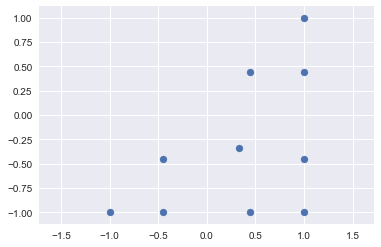

In [6]:
fig, ax = plt.subplots()
plt.scatter(mt.nodal_pts[:,0], mt.nodal_pts[:,1])
ax.axis('equal')
plt.show()

We can run the following benchmarking code (expensive), and generate a plot of wallclock time for master element initialization.

```python
master_init_times = []
for p in range(1, 11):
    start = time.clock()
    master_obj = mkm.Master_nodal(order=p, dim=2, element=0)
    end = time.clock()
    elapsed = end - start
    master_init_times.append(elapsed)
```

from which we plot
<img src="img/MPU_master_tri_init_times.png" alt="drawing" style="width: 500px;"/>

this is really slow. If we would like to play with higher order elements, we need a more efficient way of initializing these master elements.

# 2D triangle: basis and master element creation

## barycentric coordinate tools

In order to position points on the triangle, it will be convenient to work in [Barycentric coordinates](https://en.wikipedia.org/wiki/Barycentric_coordinate_system).
The following define the transformation to and from barycentric coordinates from cartesian coords.

In [7]:
# %load -s cart2bary,bary2cart ../src/fem_base/master/barycentric_coord_tools.py
def cart2bary(verts, pts):
    """ retrns barycentric coords of pt on a tri w/ vertices verts
    @param verts  tuple of tuples specifying verts
    @param pt  numpy array of point on triangle shape (2, npts)
    """
    npts = pts.shape[1]
    _lambda = np.zeros((3, npts))
    (x1, y1), (x2, y2), (x3, y3) = verts
    T = np.array([[x1 - x3, x2 - x3],
                  [y1 - y3, y2 - y3]])
    r = np.copy(pts)
    r[0,:] -= x3
    r[1,:] -= y3

    _lambda[:2, :] = np.linalg.solve(T, r)
    _lambda[2, :] = 1 - _lambda[0,:] - _lambda[1,:]
    return _lambda

def bary2cart(verts, _lambda):
    """converts from barycentric to cartesian coordinates
    @param verts  tuple of tuples specifying triangle vertices
    @param _lambda array of barycentric points (3, npts)
    """
    npts = _lambda.shape[1]
    λ1, λ2, λ3 = _lambda[0,:], _lambda[1,:], _lambda[2,:]
    x, y = np.zeros(npts), np.zeros(npts)
    (x1, y1), (x2, y2), (x3, y3) = verts
    x = λ1*x1 + λ2*x2 + λ3*x3
    y = λ1*y1 + λ2*y2 + λ3*y3
    return x, y


The following generates the barycentric coordinates corresponding to uniform nodes on a triangle for a polynomial order $p$.

In [8]:
# %load -s uniform_bary_coords ../src/fem_base/master/barycentric_coord_tools.py
def uniform_bary_coords(p):
    """ generate bary coords of uniform nodal pts for tri of order p"""
    N, Np = p, int((p+1)*(p+2)/2)
    node = 0
    bary = np.zeros((3, Np))
    for i in range(N+1):
        for j in range(N+1-i):
            λ1, λ2 = i/N, j/N
            λ3 = 1 - λ1 - λ2
            bary[:, node] = np.asarray([λ1, λ2, λ3])
            node += 1
    return bary


In [9]:
# serves as a view mesh for the shape functions we are about to create
p = 24
Np = int((p+1)*(p+2)/2)
bary = uniform_bary_coords(p)
verts = ((-1, -1), (-1, 1), (1, -1))
x, y = bary2cart(verts, bary)

## modal basis: generating orthonormal polynomials

We need a way to generalize the 1D orthonormal polynomial basis to that over the standard simplex

$$T \equiv \{\mathbf{r}=(\xi, \eta) \mid (\xi, \eta) \leq -1; \xi+\eta \leq0\}$$

such that we can efficiently compute $\psi_m(\mathbf{r})$ over $T$. In Hesthaven and Warburton, the suggestion is to use the basis defined by

\begin{align}
   m(i,j) &= j + (N+1)i + 1 - \frac{i}{2}(i-1) \\
   \psi_m(\mathbf{r}) &= \sqrt{2} P_i(a) \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \\
   &a = 2 \frac{1+\xi}{1-\eta} - 1, b=\eta
\end{align}

Where $P_n^{(\alpha, \beta)}$(x) is the familiar $n^{th}$ order Jacobi polynomial over [-1, 1] discussed in depth in the `1D_basis_and_master` tutorial. We leverage `orthopy` in order to generate these polynomials over barycentric coordinates, and supply the master element vertices to create the basis over $T$. However, we will need these relations in order to compute the derivatives of the shape functions.

In [10]:
# %load -s xi_eta_to_ab ../src/fem_base/master/polynomials_2D.py
def xi_eta_to_ab(ξ, η):
    """ function to transform xi, eta coords to a, b
    see Hesthaven function 'rstoab'
    @param xi, eta vectors of xi, eta pts
    """
    a, b = np.zeros_like(ξ), np.zeros_like(η)
    singular = np.isclose(η, 1.0)
    nonsingular = np.logical_not(singular)
    a[nonsingular] = 2*(1. + ξ[nonsingular])/(1 - η[nonsingular]) - 1
    a[singular] = -1
    b = η
    return a, b


In [11]:
# %load -s Simplex2DPoly ../src/fem_base/master/polynomials_2D.py
def Simplex2DPoly(a, b, i, j):
    """ generates the orthonormal polynomial over the master simplex (mapped to a, b coords)
    transcriber from Hesthaven 2008 (Simplex2DP.m)
    """
    h1 = p1d.JacobiP(a, 0, 0, i)
    h2 = p1d.JacobiP(b, 2*i+1, 0, j)
    P = np.sqrt(2.)*h1*h2*(1-b)**i
    return P


In [12]:
# %load -s Vandermonde2D ../src/fem_base/master/polynomials_2D.py
def Vandermonde2D(N, ξ, η):
    a, b = xi_eta_to_ab(ξ, η)
    Np = int((N+1)*(N+2)/2)
    V2d = np.zeros((len(ξ), Np))
    counter = 0
    for i in range(N+1):
        for j in range(N-i+1):
            m = j + (N+1)*i + 1 - i/2.*(i-1)
            V2d[:,counter] = Simplex2DPoly(a, b, i,j)
            counter += 1
    return V2d


(325, 10)


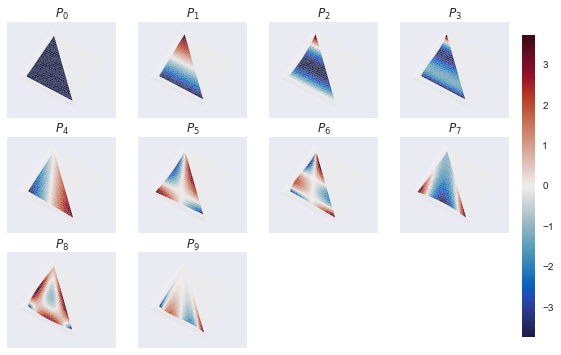

In [13]:
V2d = Vandermonde2D(3, x, y)

print(V2d.shape)

fig = plt.figure(figsize=(9,6))
tri = mtri.Triangulation(x, y)

# data limits

for gg in range(10):
    ps2d = V2d[:, gg]
    ax = fig.add_subplot(3, 4, gg+1, projection='3d')
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    cax = ax.plot_trisurf(tri, V2d[:,gg], cmap=cmo.cm.balance)
    ax.set_title(r'$P_{}$'.format(gg), y=1.06)
    ax.view_init(elev=90)
mplu.add_shared_colorbar(fig, ps2d, cmap=cmo.cm.balance)
plt.show()


Note that the Hesthaven polynomials are orthonormalized differently than the orthopy polynomials.

## modal basis: derivatives of orthonormal polynomials

\begin{align}
   m(i,j) &= j + (N+1)i + 1 - \frac{i}{2}(i-1) \\
   \psi_m(\mathbf{r}) &= \sqrt{2} P_i(a) \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \\
   &a = 2 \frac{1+\xi}{1-\eta} - 1, b=\eta
\end{align}

So naturally
<img src="img/master_tri_func_dependence.png" alt="drawing" style="width: 250px;"/>
and the chain rule suggests that

\begin{align}
  \frac{d\psi_m}{d\xi} &= \frac{\partial a}{\partial\xi}\frac{\partial\psi_m}{\partial a} 
  = \frac{2}{1 - \eta}\frac{\partial\psi_m}{\partial a} 
  = \frac{2}{1 - b} \cdot \sqrt{2} \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \frac{\partial}{\partial a}\left( P_i(a)  \right) \\
    &= 2(1-b)^{i-1}\cdot \sqrt{2} \, P_j^{(2i+1, 0)}(b)\,\frac{\partial}{\partial a}\left( P_i(a)  \right)
  \end{align}
  
  
  \begin{align}
  \frac{d\psi_m}{d\eta} &= \frac{\partial a}{\partial \eta}\frac{\partial \psi_m}{\partial a} + \frac{db}{d\eta}\frac{d\psi_m}{db}
  = \frac{2(1+\xi)}{(1-\eta)^2}\frac{\partial \psi_m}{\partial a} + \frac{d\psi_m}{db} \\
  &= \frac{2(1+\xi)}{(1-\eta)^2}\sqrt{2} \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \frac{\partial}{\partial a}( P_i(a)  ) + \sqrt{2} \,P_i(a)\frac{\partial}{db}\left((1-b)^i\,P_j^{(2i+1, 0)}(b)\right) \\
%    &= \frac{2(1+\xi)}{(1-\eta)^2}\sqrt{2} \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \frac{\partial}{\partial a}( P_i(a)  ) + \sqrt{2} \,P_i(a)\left[(1-b)^i\,\frac{\partial}{db}\left(P_j^{(2i+1, 0)}(b)\right) + P_j^{(2i+1, 0)}(b)\left(i(1-b)^{i-1}\right)\right] \\
\end{align}

We follow Hesthaven's simplified and normalized expression which is equivalent to the above.

In [14]:
# %load -s Simplex2DPolyGradient,GradVandermonde2D ../src/fem_base/master/polynomials_2D.py
def Simplex2DPolyGradient(a, b, i, j):
    """ takes derivatives of modal basis polys w/r/t ξ, η
    transcribed from Hesthaven (GradSimplex2D.m)
    """
    Pa, dP_da = p1d.JacobiP(a,0,    0,i), p1d.GradJacobiP(a,0    ,0,i)
    Pb, dP_db = p1d.JacobiP(b,2*i+1,0,j), p1d.GradJacobiP(b,2*i+1,0,j)

    # d/dξ = da/dξ * d/da + db/dξ * d/db = 2/(1-b) d/da
    dψ_dξ = dP_da * Pb
    if i > 0:
        dψ_dξ *= ( (0.5*(1-b))**(i-1) )

    # d/dη = ((1+a)/2)/((1-b)/2)d/da + d/db
    dψ_dη = dP_da * (Pb * 0.5*(1+a))
    if i > 0:
        dψ_dη *= ((0.5*(1-b))**(i-1))

    tmp = dP_db * (0.5*(1-b))**(i)
    if i > 0:
        tmp -= 0.5*i*Pb * (0.5*(1-b))**(i-1)
    dψ_dη += Pa * tmp

    # normalize both derivatives
    dψ_dξ *= 2**(i+0.5)
    dψ_dη *= 2**(i+0.5)
    return [dψ_dξ, dψ_dη]

def GradVandermonde2D(p, ξ, η):
    """ compute the derivative vandermonde matrices in ξ, η directions """
    Np = int((p+1)*(p+2)/2)
    npts = len(ξ)
    a, b = xi_eta_to_ab(ξ, η)
    dVξ, dVη = np.zeros((npts, Np)), np.zeros((npts, Np))
    counter = 0
    for i in range(p+1):
        for j in range(p-i+1):
            dψ_dξ, dψ_dη = Simplex2DPolyGradient(a, b, i, j)
            dVξ[:,counter] = dψ_dξ
            dVη[:,counter] = dψ_dη
            counter += 1
    return [dVξ, dVη]


In [15]:
# indices
p=2
gv = GradVandermonde2D(p, x, y)
V2d = Vandermonde2D(p, x, y)

Plot the polynomials, along with the derivative in each coordinate direction.

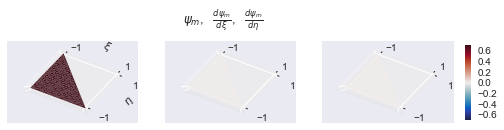

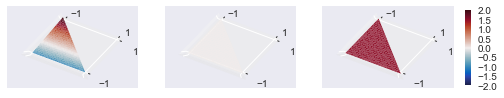

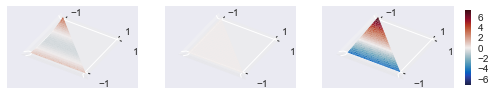

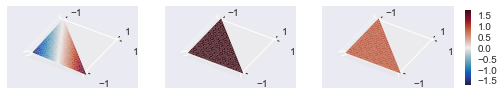

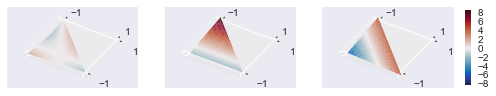

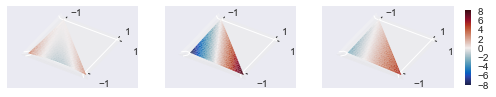

In [16]:
tri = mtri.Triangulation(x, y)
nbasis_functions = V2d.shape[1]
grid=(1,3)

for m in range(nbasis_functions):
    
    fig = plt.figure(figsize=(8, 1.5))
    counter = 1
    data = np.vstack((V2d[:,m], gv[0][:,m], gv[1][:,m]))
    dmax = np.max(np.abs(data))
    #vmax, vmin = np.max(data), np.min(data)
    vmax, vmin = dmax, -1*dmax
    
    # original polynomial
    ax = fig.add_subplot(*grid, counter, projection='3d')
    if m==0:
        ax.set_xlabel(r'$\xi$')
        ax.set_ylabel(r'$\eta$')
    ax.set_xticks([-1, 1]); ax.set_yticks([-1, 1]); ax.set_zticks([])
    cax = ax.plot_trisurf(tri, V2d[:,m], vmin=vmin, vmax=vmax, cmap=cmo.cm.balance)
    ax.view_init(elev=90)
    counter+=1

    # derivative in ξ direction
    ax = fig.add_subplot(*grid, counter, projection='3d')
    ax.set_xticks([-1, 1]); ax.set_yticks([-1, 1]); ax.set_zticks([])
    cax = ax.plot_trisurf(tri, gv[0][:,m], vmin=vmin, vmax=vmax, cmap=cmo.cm.balance)
    ax.view_init(elev=90)
    counter+=1

    # derivative in η direction
    ax = fig.add_subplot(*grid, counter, projection='3d')
    ax.set_xticks([-1, 1]); ax.set_yticks([-1, 1]); ax.set_zticks([])
    cax = ax.plot_trisurf(tri, gv[1][:,m], vmin=vmin, vmax=vmax, cmap=cmo.cm.balance)
    ax.view_init(elev=90)
    counter+=1

    mplu.add_shared_colorbar(fig, np.linspace(vmin, vmax, 100), cmap=cmo.cm.balance,
                             cbar_ax=[0.92, 0.15, 0.01, 0.7])
    if m == 0:
        fig.suptitle(r'$\psi_m$,   $\frac{d\psi_m}{d\xi}$,   $\frac{d\psi_m}{d\eta}$',
                     y=1.2)
    plt.show()

Check that the magnitudes of the constant derivatives are correct

In [17]:
# zero derivatives are zero
should_be_null = [gv[0][:,0], gv[1][:,0], gv[0][:,1], gv[0][:,2]]
assert np.all([np.allclose(arr, 0.) for arr in should_be_null])

# m = 1: dψ/dη constant is correcct
ψ1 = V2d[:,1]
slope = (np.max(ψ1) - np.min(ψ1))/2.
assert np.isclose(gv[1][:,1][0], slope)

# m = 3: dψ/dξ constant is correct
ψ3 = V2d[:,3]
slope = (np.max(ψ3) - np.min(ψ3))/2.
assert np.isclose(gv[0][:,3][0], slope)

## nodal basis: generating shape functions

Hesthaven makes the claim that $V^T \mathbf{\ell}(r) = \tilde{\mathbf{P}}(r)$. Just as we did when creating the 1D nodal shape functions, we can directly apply the relation

$$\ell = (V^T)^{-1} \tilde{\mathbf{P}}$$

which allows us to create our nodal shape functions from the orthonormal modal polynomial coefficients. 

In [18]:
p = 2
Np = int((p+1)*(p+2)/2)
bary = uniform_bary_coords(p)
verts = ((-1, -1), (-1, 1), (1, -1))
ξ, η = bary2cart(verts, bary)
V2D = Vandermonde2D(p, ξ, η)
print('shape of Vandermonde matrix: {}'.format(V2D.shape))

view_order = 32
ξ_view, η_view = bary2cart(verts, uniform_bary_coords(view_order))
P_tilde = Vandermonde2D(p, ξ_view, η_view)
Vti = np.linalg.inv(V2D.T)
nodal_shap = np.dot(Vti, P_tilde.T)
nodal_shap.shape

shape of Vandermonde matrix: (6, 6)


(6, 561)

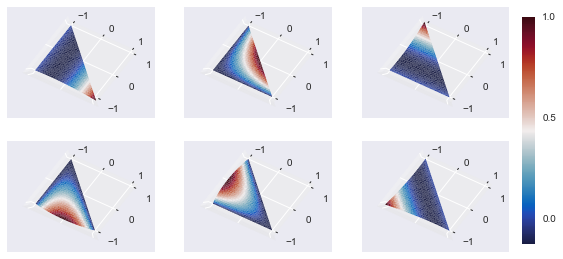

In [19]:
fig = plt.figure(figsize=(9, 4.5))
data = nodal_shap[4,:]

nb = nodal_shap.shape[0]
tri = mtri.Triangulation(ξ_view, η_view)
for i in range(nb):
    data = nodal_shap[i,:]
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.set_xticks([-1, 0, 1]); ax.set_yticks([-1,0,1]); ax.set_zticks([]);
    cax = ax.plot_trisurf(tri, data, cmap=cmo.cm.balance)
    ax.view_init(elev=90)
fig = mplu.add_shared_colorbar(fig, data, cmo.cm.balance, ticks=[0,0.5,1])
plt.show()

honestly, a height plot isn't really the best way to show this. It's a bit funny. Probably need to get `cairo` `mpl` backend working and do flat plots with shading.

## `NodalBasis2DTriangle`

We load the `NodalBasis2DTriangle` in its entirety. The class is designed to evaluate the shape functions and their derivatives over the master triangle. The user has a choice as to uniformly space the nodal points, or warp them for better interpolation properties, discussed below.

In [20]:
# %load -s NodalBasis2D ../src/fem_base/master/nodal_basis_2D.py
class NodalBasis2D(object): pass


In [21]:
# %load -s NodalBasis2DTriangle ../src/fem_base/master/nodal_basis_2D.py
class NodalBasis2DTriangle(NodalBasis2D):
    verts = ((-1, -1), (1, -1), (-1, 1))
    def __init__(self, p, nodal_locations='UNIFORM'):
        """ creates a nodal basis over master element verts
        @param p  polynomial order of the nodal basis
        @param nodal_locations
            UNIFORM: uniformly spaced nodal points (in a barycentric sense)
            WARPED:  shifted points for better interpolation behavior (Hesthaven 2008)
        """
        self.p, self.nb = p, int((p+1)*(p+2)/2.)
        if nodal_locations == 'UNIFORM':
            self.nodal_pts = self.mk_uniform_nodal_pts()
        elif nodal_locations == 'WARPED':
            self.nodal_pts = self.mk_warped_nodal_pts()
        else: raise ValueError('node_spacing {} not recognized'.format(node_spacing))

    def shape_functions_at_pts(self, pts):
        """ computes values of shape functions at pts (npts, 2) """
        V = p2d.Vandermonde2D(N=self.p, ξ=self.nodal_pts[:,0], η=self.nodal_pts[:,1])
        VTi = np.linalg.inv(V.T)
        P_tilde = p2d.Vandermonde2D(N=self.p, ξ=pts[:,0], η=pts[:,1])
        shap = np.dot(VTi, P_tilde.T)
        return shap.T

    def shape_function_derivatives_at_pts(self, pts):
        """ compute the derivatives of shape fns in ξ, η directions at pts
        returns list of derivatives of shape functions indexed by coord direction
        """
        V = p2d.Vandermonde2D(N=self.p, ξ=self.nodal_pts[:,0], η=self.nodal_pts[:,1])
        dψ_dξ, dψ_dη = p2d.GradVandermonde2D(p=self.p, ξ=pts[:,0], η=pts[:,1])
        Vinv = np.linalg.inv(V)
        shap_der = [np.dot(dψ_dξ, Vinv), np.dot(dψ_dη, Vinv)]
        return shap_der

    def mk_uniform_nodal_pts(self):
        """ make uniformly spaced pts (barycentric sense) on the master element """
        uniform_bary_coords = bct.uniform_bary_coords(self.p)
        xp, yp = bct.bary2cart(self.verts, uniform_bary_coords)
        nodal_pts = np.vstack((xp, yp)).T
        return nodal_pts

    def mk_warped_nodal_pts(self, α=0.):
        """ compute warped nodal points on the order p master triangle
        @param α  blending constant, see Hesthaven p.179
        NOTE: Hesthaven uses scaled barycentric coords, so we transcribe
            Nodes2D.m, xytors.m directly rather than rescale things. This is done
            for readability in comparison to the Hesthaven text.
        """
        p = self.p
        λ1, λ2, λ3 = bct.uniform_bary_coords(p)
        x, y = -λ2 + λ3, (-λ2 - λ3 + 2*λ1) / np.sqrt(3)

        # warping and blending functions
        wt1, wt2, wt3 = self._w_t(p, λ3-λ2), 0.5*self._w_t(p, λ1-λ3), 0.5*self._w_t(p,λ2-λ1)
        b1, b2, b3 = 4*λ3*λ2, 4*λ3*λ1, 4*λ2*λ1
        w1, w2, w3 = wt1*b1*(1+(α*λ1)**2), wt2*b2*(1+(α*λ2)**2), wt3*b3*(1+(α*λ3)**2)

        # move the cartesian points on the equilateral triangle
        x += (1)*w1 + (-1)        *w2 + (-1)         *w3
        y += (0)*w1 + (np.sqrt(3))*w2 + (-np.sqrt(3))*w3

        # map back to master element from equilateral triangle
        λ1, λ2, λ3 = (np.sqrt(3)*y+1)/3, (-3*x-np.sqrt(3)*y+2)/6, (3*x-np.sqrt(3)*y+2)/6
        xp, yp = -λ2 + λ3 - λ1, -λ2 -λ3 + λ1
        nodal_pts = np.vstack((xp, yp)).T
        return nodal_pts

    def _w_t(self, p, pts):
        """ evaluate 1D warp factor w_tilde at order N at pts
        NOTE: see Hesthaven p.176
        """
        nb1d = NB1D.NodalBasis1D(p=p, node_spacing='EQUIDISTANT')
        shap = nb1d.shape_functions_at_pts(pts)

        r_eq = nb1d.nodal_pts
        r_LGL, _ = NB1D.LegendreGaussLobatto(nb1d.nb)

        numerator = np.dot(shap, r_LGL - r_eq)
        denom = 1 - pts**2
        denom[np.isclose(denom, 0.)] = 1  # don't divide by 0, numerator 0 here
        wr = numerator / denom
        return wr


## nodal basis: visualization

We define two `NodalBasis2DTriangle` instances. The first are the order $p=3$ uniform nodes whose shape functions we would like to plot. We will evaluate the shape functions at the uniform nodal points of a much higher order element.

In [22]:
nb_plot = NodalBasis2DTriangle(p=3)
nbp_fine = NodalBasis2DTriangle(p=25)
view_pts = nbp_fine.nodal_pts

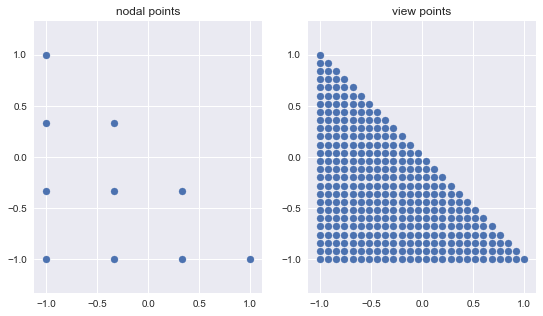

In [23]:
nx, ny = nb_plot.nodal_pts.T
x, y = view_pts.T

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(nx, ny)
ax.axis('equal')
ax.set_title('nodal points')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(x, y)
ax.set_title('view points')
ax.axis('equal')
plt.show()

In [24]:
def plot_nodal_shape_functions(fig, grid, nodal_basis, view_points):
    shap = nodal_basis.shape_functions_at_pts(view_pts)
    x, y = view_pts.T
    tri = mtri.Triangulation(x, y)
    for i in range(nodal_basis.nb):
        data = shap[:,i]
        ax = fig.add_subplot(*grid, i+1, projection='3d')
        ax.set_xticks([-1, 0, 1]); ax.set_yticks([-1,0,1]); ax.set_zticks([]);
        cax = ax.plot_trisurf(tri, data, cmap=cmo.cm.balance, vmax=np.max(shap), vmin=np.min(shap))
        ax.view_init(elev=75, azim=-70)
    fig = mplu.add_shared_colorbar(fig, shap, cmo.cm.balance, ticks=[0,0.5,1])
    fig.suptitle(r'nodal shape functions, $p = {}$'.format(nodal_basis.p), y=0.92)
    return fig

Plot the nodal shape functions.

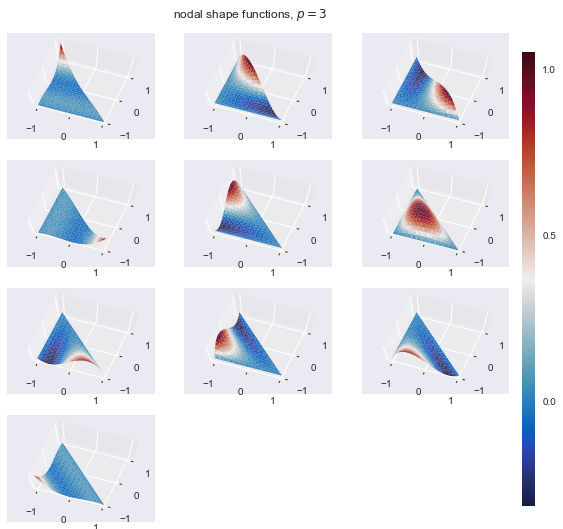

In [25]:
fig = plt.figure(figsize=(9, 9))
grid = (4,3)
fig = plot_nodal_shape_functions(fig, grid, nb_plot, view_pts)
plt.show()

## nodal basis: node warping and blending

All of the developments so far have been agnostic to choice of where the nodal points were placed, but (as in 1D), the equally spaced points are not optimal for interpolation and are susceptible to Runge phenomenon. In this section, we consider a method by which we can perturb the nodal points for good interpolation behavior.

the warping function is quantity defined over the 1D master element [-1, 1] as 

\begin{align}
    \tilde{w}(r) \equiv \frac{ \sum_{i=1}^{N_p} (r_i^{LGL} - r_i^{eq})\phi^{eq}_i(r)}{1 - r^2}
\end{align}

where $r_i^{LGL},\, r_i^{eq}$ are the $i^{th}$ LegendreGaussLobatto and equally spaced points, respectively, and $\phi_i^{eq}$ are the nodal 1D shape functions defined over the equally spaced points $r_i^{eq}$. Note that we can use leverage our `NodalBasis1D` class in order to do this in the class definition above.

Let's look at the difference between the warped points and the uniform points at different element orders:

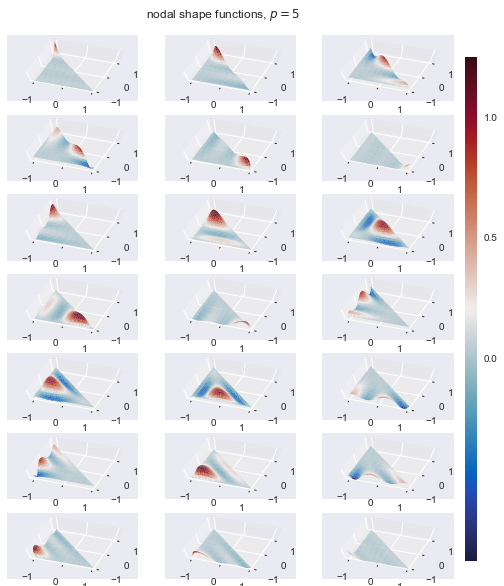

In [26]:
nb_plot = NodalBasis2DTriangle(p=5, nodal_locations='UNIFORM')
nbp_fine = NodalBasis2DTriangle(p=30)
view_pts = nbp_fine.nodal_pts

fig = plt.figure(figsize=(8, 10))
grid = (7,3)
fig = plot_nodal_shape_functions(fig, grid, nb_plot, view_pts)
plt.show()

We can start to see some Runge phenomena even at $p=5$. Note that the shape functions exceed 1 and dip far below 0. by contrast, warping the nodal locations makes the shape functions much better behaved.

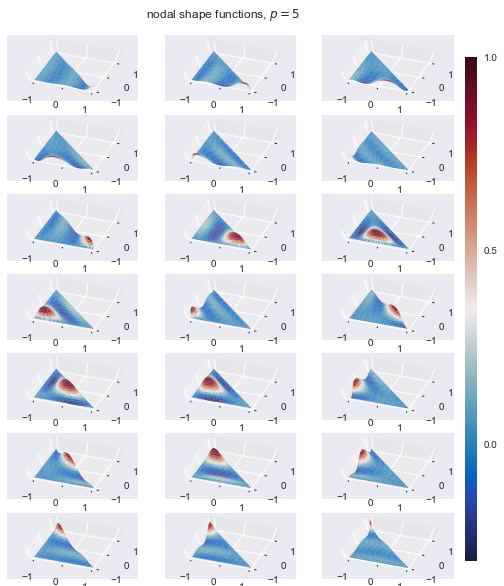

In [27]:
nb_plot = NodalBasis2DTriangle(p=5, nodal_locations='WARPED')
nbp_fine = NodalBasis2DTriangle(p=30)
view_pts = nbp_fine.nodal_pts

fig = plt.figure(figsize=(8, 10))
grid = (7,3)
fig = plot_nodal_shape_functions(fig, grid, nb_plot, view_pts)
plt.show()

So we see that it is in our interest to warp the nodal points when we are considering high-order elements.

## master triangle

### quadrature over the master triangle

We use the stable and open source library `quadpy` to obtain integration points over the triangle, via a small adapter function. By default, we use the Xiao Gimbutas schemes from 2010 (up to order 50).

In [28]:
# %load -s triangle_quadrature ../src/fem_base/master/master_2D.py
def triangle_quadrature(n, verts):
    """ look up / compute quadrature rule over the triangle, order n
    @param n  the order of polynomial which should be integrated exactly
    @param verts  tuple of tuples defining the master element
    NOTE: leverages quadpy, 2*weights
    """
    if n > 50:
        raise NotImplementedError
    qr = quadpy.triangle.xiao_gimbutas.XiaoGimbutas(index=n)
    bary, weights = qr.bary, qr.weights
    xq, yq = bct.bary2cart(verts=verts, _lambda=bary.T)
    points = np.vstack((xq, yq)).T
    return points, 2*weights


In [29]:
# %load -s Master2D ../src/fem_base/master/master_2D.py
class Master2D(object):

    def mk_shap_and_dshap_at_pts(self, pts):
        shap = self.basis.shape_functions_at_pts(pts)
        dshap = self.basis.shape_function_derivatives_at_pts(pts)
        return shap, dshap


In [132]:
# %load -s Master2DTriangle ../src/fem_base/master/master_2D.py
class Master2DTriangle(Master2D):
    """ note vertex definitions in nodal_basis_2D.py """
    def __init__(self, p, nquad_pts=None, *args, **kwargs):
        self.p, self.dim = p, 2
        self.basis = nb2d.NodalBasis2DTriangle(self.p, **kwargs)
        self.nb, self.verts, self.n_ed = self.basis.nb, self.basis.verts, 3
        self.nodal_pts = self.basis.nodal_pts
        self.nq = 2*self.p +2 if nquad_pts is None else nquad_pts
        self.quad_pts, self.wghts = triangle_quadrature(self.nq, self.verts)

        # shape functions at nodal and quadrature points
        self.shap_quad,  self.dshap_quad = self.mk_shap_and_dshap_at_pts(self.quad_pts)
        self.shap_nodal, self.dshap_nodal = self.mk_shap_and_dshap_at_pts(self.nodal_pts)

        # mass, stiffness matrices
        self.M, self.S, self.K = self.mk_M(), self.mk_S(), self.mk_K()
        self.Minv = np.linalg.inv(self.M)

        # compute nodal ids of edge nodes, as well as the lifting matrix
        self.ids_ed = self.find_nodes_on_edges()
        self.nr = sum([len(ids) for ids in self.ids_ed])
        self.L = self.mk_L()
        self.edge_normals = np.array([[1, 1], [-1, 0], [0, -1]])

    def mk_M(self):
        """ the mass matrix, M_ij = (phi_i, phi_j) """
        shapw = np.dot(np.diag(self.wghts), self.shap_quad)
        M = np.dot(self.shap_quad.T, shapw)
        return M

    def mk_S(self):
        """ the stiffness matrix, S[k]_ij = (phi_i, \frac{d\phi_j}{dx_k})
        returns a list indexed by coordinate direction on the master element
        """
        S = [None, None]
        for i in range(self.dim):
            dshapw = np.dot(np.diag(self.wghts), self.dshap_quad[i])
            S[i] = np.dot(self.shap_quad.T, dshapw)
        return S

    def mk_K(self):
        """ the stiffness matrix, K_ij = (\frac{d\phi_i}{dx_k}, \frac{d\phi_j}{dx_k})
        returns a list indexed by coordinate direction on the master element
        """
        K = [None, None]
        for i in range(self.dim):
            dshapw = np.dot(np.diag(self.wghts), self.dshap_quad[i])
            K[i] = np.dot(self.dshap_quad[i].T, dshapw)
        return K

    def find_nodes_on_edges(self):
        """ computes the node numbers (ids) on each edge
        the i^th barycentric coord of a point on a tri edge will be 0, find these pts
        @retval ids_ed  list of vectors indexed by edge number
        NOTE: we manually flip edges 0 and 2 to ensure CCW ordering of ed dof around the element
        """
        ids_ed = [None, None, None]
        bary_coords = bct.cart2bary(self.verts, self.nodal_pts.T)
        ids_ed[0] = np.where( np.isclose(bary_coords[0, :], 0.) )[0][::-1]
        ids_ed[1] = np.where( np.isclose(bary_coords[1, :], 0.) )[0]
        ids_ed[2] = np.where( np.isclose(bary_coords[2, :], 0.) )[0][::-1]
        return ids_ed

    def mk_L(self):
        """ makes the elemental lifting matrix """
        L = np.zeros((self.nb, self.nr), dtype=int)
        for ed_dof, interior_dof in enumerate(np.hstack(self.ids_ed)):
            L[interior_dof, ed_dof] = 1
        return L


### lifting matrix and edge data structures

barycentric coordinates provide an excellent way to find the nodal points on the edge of the element $\lambda_1, \lambda_2, \lambda_3$ will be 0 if the point is on edge 1, 2, 3, respectively.

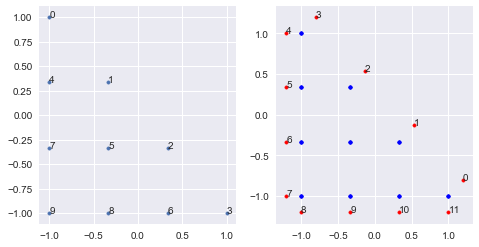

In [147]:
mt = Master2DTriangle(p=3, nodal_locations='UNIFORM')
xn, yn = mt.nodal_pts.T

# draw the interior nodes
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(xn, yn, s=12)
for idx, (xn, yn) in enumerate(mt.nodal_pts):
    ax.annotate(idx, (xn, yn))
    
# draw the element edge space nodes
ax = fig.add_subplot(1, 3, 2)
shift = 0.2
counter = 0
for edge, ids_ed in enumerate(mt.ids_ed):
    nx, ny = mt.edge_normals[edge].T
    edx, edy = mt.nodal_pts[ids_ed, :].T
    edx += shift * nx
    edy += shift * ny
    ax.scatter(edx, edy, c='r', s=12)
    for n in range(len(ids_ed)):
        ax.annotate(counter, (edx[n], edy[n]))
        counter += 1
    ax.scatter(mt.nodal_pts[:,0], mt.nodal_pts[:,1], c='b', s=12)

plt.show()

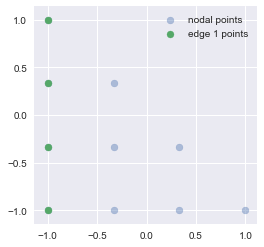

In [134]:
# compute the points on each edge with bary coords
edge = 1
edge_indices = mt.ids_ed[edge]

fig, ax = plt.subplots(figsize=(4,4))
xn, yn = mt.nodal_pts.T
ax.scatter(xn, yn, alpha=0.4, label='nodal points')
ax.scatter(xn[edge_indices], yn[edge_indices], label='edge {} points'.format(edge))
ax.legend()
plt.show()

In [149]:
interior_numbers = np.arange(mt.nb)
edge_numbers = np.ones(mt.nr, dtype=int)

interior2edge = np.dot(mt.L, edge_numbers)
print(interior2edge)

edge2interior = np.dot(mt.L.T, interior_numbers)
print(edge2interior)

[2 1 1 2 1 0 1 1 1 2]
[3 2 1 0 0 4 7 9 9 8 6 3]


### performance test for master element initialization

In [33]:
# sort of unit test
for p in range(1, 5):
    mt = Master2DTriangle(p=p, nodal_locations='WARPED')
    mt2 = mkm.Master_nodal(order=p, dim=2, element=0)
    assert(np.allclose(mt.M, mt2.M))

In [34]:
p=1
mt = Master2DTriangle(p=p, nodal_locations='WARPED')
mt2 = mkm.Master_nodal(order=p, dim=2, element=0)
print(mt2.K[0])
print()
print(mt.S[0].T)
print()
print(np.dot(mt.Minv, mt.dshap_nodal[0]).T)

[[-0.33333333 -0.33333333 -0.33333333]
 [ 0.33333333  0.33333333  0.33333333]
 [ 0.          0.          0.        ]]

[[ 0.33333333  0.33333333  0.33333333]
 [-0.33333333 -0.33333333 -0.33333333]
 [ 0.          0.          0.        ]]

[[ 0.75  0.75  0.75]
 [-0.75 -0.75 -0.75]
 [ 0.    0.    0.  ]]


Let's integrate the volume of the master element

In [35]:
master_init_times = []
for p in range(1, 21):
    start = time.clock()
    master_obj = Master2DTriangle(p=p)
    end = time.clock()
    elapsed = end - start
    master_init_times.append(elapsed)

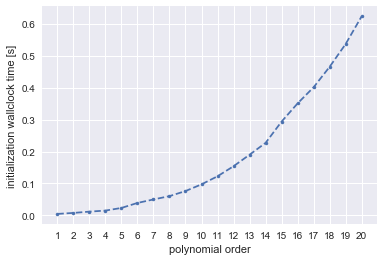

In [36]:
x = np.arange(1, 21)
plt.plot(x, master_init_times, '.--')
plt.xlabel('polynomial order')
plt.ylabel('initialization wallclock time [s]')
plt.xticks(x)
plt.show()

0.7 seconds for an order 20 element! We have reduced initialization time by 3 orders of magnitude!

## master quadrilateral

# 2D quad: basis and master element creation

Creation of a nodal basis and subsequent quadrilateral master element is intrinsically simpler than that of the master triangle, because we can form the relevant data structures by taking tensor products of the well conditioned 1D objects, due to the inherently cubic nature of the element. This is what Hesthaven suggests (citation needed).

# TODO

## functionality
- lifting matrix, master element normals

## unit tests
- unit test where we transform from bary 2 cart 2 bary again
- unit test where we integrate the polys and recover the identity matrix
- unit test where we check Lesbesgue constant and compare to Hesthaven's
- hit polynomial functions with Dr to see if they converge to check derivatives